In [1]:
from collections import Counter, defaultdict

import pandas as pd
import re
import string
import spacy
import matplotlib.pyplot as plt
import pytextrank
import seaborn as sns
from wordcloud import WordCloud
import stylecloud
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load("en_core_web_md")

import sys
sys.path.insert(0, '../src')
from text_operations import TextPreprocessor, ComplexityComputer
import data_manipulation as dm

In [2]:
df = pd.read_csv("../../data_collection/data/labelled/masters_data_programs_india_usa.csv")
df.shape

(111, 31)

## 1. Descriptive Statistics, Compute Complexity
> Computing complexity measures and other descriptive stats of the program descriptions

In [3]:
categorical_features = [
    'id', 'type', 'country', 'band', 'subject', 'dept_cat'
]

quant_features = [
    'national_rank_qs',
]

In [4]:
textual_complexity_df = ComplexityComputer(df.loc[0, 'descr']).get_complexity_measures()
for idx in range(1, df.shape[0]):
    temp = ComplexityComputer(df.loc[idx, 'descr']).get_complexity_measures()
    textual_complexity_df = pd.concat([textual_complexity_df, temp])

textual_complexity_df = textual_complexity_df.reset_index(drop=True)
textual_complexity_df['pid'] = df['id']
textual_complexity_df.head()

,text,char_cnt,word_cnt,sent_cnt,digits_cnt,mean_chars_per_word,median_chars_per_word,mean_words_per_sent,median_words_per_sent,common_nouns_prop,proper_nouns_prop,adjectives_prop,verbs_prop,numerals_prop,flesch_kincaid,dale_chall,mtld,pid
0,Computational Science and Data Science are int...,687,88,3,0,6.738636,7.0,29.333333,28.0,0.363636,0.079545,0.170455,0.090909,0.000000,21.7,11.61,46.951849,Indian Institute of Science Bangalore - M.Tech...
1,Artificial Intelligence has captured the ima...,1566,244,13,4,5.368852,4.0,18.769231,18.0,0.299180,0.094262,0.114754,0.090164,0.016393,14.6,10.41,79.344978,Indian Institute of Science Bangalore - M.Tech...
2,The School has launched a two year MBA in Bus...,2911,419,25,12,5.832936,6.0,16.760000,13.0,0.298329,0.159905,0.059666,0.083532,0.019093,17.5,9.27,59.886627,University of Hyderabad - MBA Business Analytics
3,M.Tech Artificial Intelligence is also a four...,384,61,4,3,5.278689,4.0,15.250000,11.5,0.327869,0.049180,0.114754,0.065574,0.049180,14.4,9.76,67.280000,University of Hyderabad - M.Tech. Artificial I...
4,Data Science is gaining prominence in academi...,1101,159,14,5,5.767296,5.0,11.357143,10.0,0.364780,0.050314,0.088050,0.125786,0.031447,10.1,9.24,80.397106,IIT Guwahati - M.Tech Data Science


In [5]:
# for summary stats
textual_complexity_df.describe()

,char_cnt,word_cnt,sent_cnt,digits_cnt,mean_chars_per_word,median_chars_per_word,mean_words_per_sent,median_words_per_sent,common_nouns_prop,proper_nouns_prop,adjectives_prop,verbs_prop,numerals_prop,flesch_kincaid,dale_chall,mtld
count,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000
mean,1295.414414,194.162162,9.252252,2.099099,5.572910,5.090090,22.535759,22.036036,0.308963,0.083028,0.087354,0.127548,0.008687,20.419820,10.734234,74.763731
std,1025.046965,150.835283,7.451014,3.313759,0.360267,0.847987,8.752597,9.233022,0.076005,0.055941,0.031491,0.069030,0.011676,8.852301,1.364508,25.134515
min,12.000000,2.000000,1.000000,0.000000,4.585227,4.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.040816,0.000000,2.900000,8.090000,2.000000
25%,660.500000,94.500000,4.000000,0.000000,5.340987,4.500000,17.750000,16.500000,0.286421,0.046333,0.069092,0.097210,0.000000,15.750000,9.775000,58.918856
50%,1141.000000,175.000000,7.000000,1.000000,5.564286,5.000000,21.250000,21.500000,0.307692,0.076923,0.084112,0.117647,0.004695,18.500000,10.600000,75.776202
75%,1625.000000,253.000000,12.500000,3.000000,5.773258,6.000000,27.512500,26.250000,0.349658,0.112526,0.101696,0.138656,0.012906,21.950000,11.575000,92.085147
max,8052.000000,1182.000000,53.000000,21.000000,6.738636,7.000000,62.000000,62.000000,0.517857,0.317308,0.178571,0.500000,0.060606,54.200000,15.110000,161.000000


In [6]:
# merge with original to form new dataframe
df_complexity_merged = pd.merge(df, textual_complexity_df, left_on='id', right_on='pid')
df_complexity_merged = df_complexity_merged.drop('pid', axis=1)
df_complexity_merged.shape

(111, 48)

In [7]:
df_complexity_merged[df_complexity_merged.country=="India"].describe().T

,count,mean,std,min,25%,50%,75%,max
national_rank_qs,30.0,28.933333,13.952959,2.000000,21.500000,28.000000,41.000000,49.000000
"Data Gathering, Preparation and Exploration",30.0,0.090070,0.050446,0.000000,0.074786,0.095238,0.126995,0.175439
Data Representation and Transformation,30.0,0.208684,0.069452,0.083333,0.175000,0.200000,0.226608,0.500000
Computing with Data,30.0,0.418178,0.084320,0.245614,0.375845,0.412281,0.460440,0.700000
Data Modeling,30.0,0.184513,0.068993,0.000000,0.158398,0.193996,0.223703,0.294118
Data Visualization and Presentation,30.0,0.081976,0.056793,0.000000,0.030688,0.093074,0.130942,0.175439
Science about Data Science,30.0,0.016579,0.024061,0.000000,0.000000,0.000000,0.030950,0.083333
Not determinable,30.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
gds_score,30.0,0.150570,0.045090,0.087191,0.122476,0.145490,0.169298,0.273252
char_cnt,30.0,1447.500000,1618.961603,12.000000,513.000000,1016.500000,1617.750000,8052.000000


In [8]:
df_complexity_merged[df_complexity_merged.country=="USA"].describe().T

,count,mean,std,min,25%,50%,75%,max
national_rank_qs,81.0,23.308642,13.504297,1.000000,15.000000,21.000000,34.000000,48.000000
"Data Gathering, Preparation and Exploration",81.0,0.141214,0.046346,0.000000,0.111111,0.153846,0.166667,0.240000
Data Representation and Transformation,81.0,0.178374,0.044198,0.071429,0.157895,0.181818,0.200000,0.333333
Computing with Data,81.0,0.316259,0.083549,0.200000,0.250000,0.282609,0.375000,0.533333
Data Modeling,81.0,0.207606,0.053884,0.066667,0.176471,0.195652,0.230769,0.428571
Data Visualization and Presentation,81.0,0.140622,0.055391,0.000000,0.111111,0.156250,0.181818,0.227273
Science about Data Science,81.0,0.015925,0.027267,0.000000,0.000000,0.000000,0.032258,0.125000
Not determinable,81.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
gds_score,81.0,0.108631,0.037145,0.051747,0.083405,0.094097,0.134858,0.210819
char_cnt,81.0,1239.086420,694.787525,199.000000,711.000000,1176.000000,1629.000000,3130.000000


<AxesSubplot:xlabel='word_cnt', ylabel='country'>

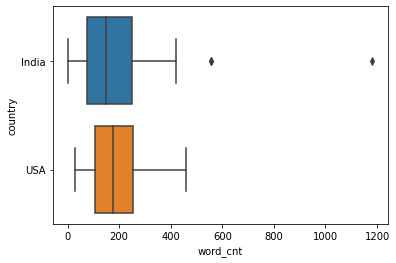

In [9]:
sns.boxplot(data=df_complexity_merged, x='word_cnt', y='country')

## 2. Keyword Extraction from Program Descriptions

> TextRank algo used as frequency-based keyword etxraction would perform poorly in this context. Program descriptions will not have many words repeated.

In [10]:
# key word extraction
if "textrank" not in nlp.pipe_names:
    nlp.add_pipe("textrank")

def keyword_extraction(text):

    keywords = []

    doc = nlp(text)
    for phrase in doc._.phrases:
        keywords.append(phrase.text)
    
    # extract top 15 or less keywords
    keywords = [kword.lower() for kword in keywords[:15]]
    return (";".join(keywords))

df['descr_keywords'] = df.descr.apply(keyword_extraction)

In [11]:
df.descr_keywords.head(10)

0    scientific computing applications;applications...
1    ai research;ai;e-governance services;deep tech...
2    business analytics;business analytics programm...
3    project work;work;data mining;other emerging t...
4    trained resources;diverse research disciplines...
5    ai academics;iit hyderabad;ai;machine learning...
6    ethical practices;computer engineering solutio...
7    financial institutions;indian university;m.sc;...
8    business analytics programme;business analytic...
9    spatial data;earth observing data;geo-intellig...
Name: descr_keywords, dtype: object

## 3. Wordcloud Visualization of Keywords in Program Descriptions

In [30]:
def process_keywords(kword_string, delim=';'):

    all_kwords = kword_string.split(delim)
    kword_freq = Counter(all_kwords)
    unique_kwords = list(kword_freq.keys())

    return kword_freq, unique_kwords

def plot_wordclouds(df, cat_col=None, cats=None, all_pgms=False):
    """
    Plot wordclouds of keywords
    """

    if not(all_pgms):
        for cat in cats:
            df_sub = df[df[cat_col] == cat]
            kword_string = ";".join(df_sub.descr_keywords)
            kword_freq, unique_kwords = process_keywords(kword_string)

            stylecloud.gen_stylecloud(
                text = kword_freq,
                max_words = 200,
                icon_name = 'fas fa-graduation-cap',
                colors = ['#cb001c', '#0071b3', '#ffc107', '#2f9171'],
                output_name = "wordcloud_keywords_" + cat_col + "_" + cat + ".png",
                gradient = 'horizontal',
                random_state=42)  
    else:
        kword_string = ";".join(df.descr_keywords)
        kword_freq, unique_kwords = process_keywords(kword_string)
        stylecloud.gen_stylecloud(
                text = kword_freq,
                max_words = 200,
                icon_name = 'fas fa-graduation-cap',
                colors = ['#cb001c', '#0071b3', '#ffc107', '#2f9171'],
                output_name = "wordcloud_keywords.png",
                gradient = 'horizontal',
                random_state=42)  

In [31]:
# for all programs
kword_string = ";".join(df.descr_keywords)
kword_freq, unique_kwords = process_keywords(kword_string)

In [ ]:
# generate wordclouds
plot_wordclouds(df, all_pgms=True)
plot_wordclouds(df, 'type', ['Public', 'Private'])
plot_wordclouds(df, 'country', ['India', 'USA'])
plot_wordclouds(df, 'dept_cat', ["Engineering-related", "Management-related", "Data-related"])
plot_wordclouds(df, 'subject', ["Data Science", "Business Analytics", "Analytics", "Artificial Intelligence"])

## 4. Program Webpage Element Analysis

In [46]:
webpage_elements = [
    'country', 'dept_cat', 'subject',
    'header_tag', 'header_names', 'links',
    'html_tags', 'html_tag_freq', 'html_emphasized_elements'
]
df_web = df[webpage_elements]

In [47]:
df_web.head(3)

,country,dept_cat,subject,header_tag,header_names,links,html_tags,html_tag_freq,html_emphasized_elements
0,India,Data-related,Data Science,"['h1', 'h2', 'h3']","[['\n\t\t\tCourse Degree Admissions, 2021\t\t'...",['https://iisc.ac.in/admissions/m-tech-m-des/'...,"['header', 'h1', 'div', 'ul', 'li', 'span', 's...","{'header': 1, 'h1': 1, 'div': 1, 'ul': 6, 'li'...","['the m.tech. (cds) admission process', 'downl..."
1,India,Engineering-related,Artificial Intelligence,"['h1', 'h2']","[['MTech (AI) @ IISc'], ['Admissions 2021 – Ap...","['https://ai.iisc.ac.in', 'https://admissions-...","['h1', 'p', 'img', 'p', 'strong', 'a', 'p', 'h...","{'h1': 1, 'p': 18, 'img': 2, 'strong': 15, 'a'...",['written test will be held online with remote...
2,India,Management-related,Business Analytics,"['h2', 'h4']","[['MBA Business Analytics'], ['Highlights of t...",no links in useful area,"['article', 'div', 'h2', 'p', 'h4', 'ul', 'li'...","{'article': 1, 'div': 1, 'h2': 1, 'p': 9, 'h4'...","['guest lectures', 'semester-4', 'continuous e..."


In [48]:
def remove_unnecessary_whitespace(text):
    text = text.replace("'", "").replace('"', '')
    text = text.replace('\\t', '').replace('\\n', '').replace('[', '').replace(']', '')
    text = re.sub(' +', ' ', text)
    text = text.translate({ord(k): ' ' for k in string.punctuation})
    text = text.strip()
    return text

def get_element_text(elements, length=False):

    text = elements.split(',')
    text = [remove_unnecessary_whitespace(g).lower() for g in text]
    text = list(set(text))
    if length:
        return len(text)
    return text

def get_element_text_str(elements):

    text = elements.split(',')
    text = [remove_unnecessary_whitespace(g).lower() for g in text]
    text = list(set(text))
    
    return ";".join(text)



In [49]:
df_web['header_elements'] = df_web.header_names.apply(get_element_text_str)
df_web['emphasized_elements_text'] = df_web.html_emphasized_elements.apply(get_element_text_str)
df_web['num_emphasized_elements'] = df_web.html_emphasized_elements.apply(lambda x: get_element_text(x, True))
df_web['num_headers'] = df_web.header_names.apply(lambda x: get_element_text(x, True))
df_web['num_links'] = df_web.links.apply(lambda x: get_element_text(x, True))

<ipython-input-49-49afea2885d3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_web['header_elements'] = df_web.header_names.apply(get_element_text_str)
<ipython-input-49-49afea2885d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_web['emphasized_elements_text'] = df_web.html_emphasized_elements.apply(get_element_text_str)
<ipython-input-49-49afea2885d3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [50]:
df_web.head()

,country,dept_cat,subject,header_tag,header_names,links,html_tags,html_tag_freq,html_emphasized_elements,header_elements,emphasized_elements_text,num_emphasized_elements,num_headers,num_links
0,India,Data-related,Data Science,"['h1', 'h2', 'h3']","[['\n\t\t\tCourse Degree Admissions, 2021\t\t'...",['https://iisc.ac.in/admissions/m-tech-m-des/'...,"['header', 'h1', 'div', 'ul', 'li', 'span', 's...","{'header': 1, 'h1': 1, 'div': 1, 'ul': 6, 'li'...","['the m.tech. (cds) admission process', 'downl...",2021;about the m tech cds program;m tech ...,please contact chair cds iisc ac in replace ...,31,5,9
1,India,Engineering-related,Artificial Intelligence,"['h1', 'h2']","[['MTech (AI) @ IISc'], ['Admissions 2021 – Ap...","['https://ai.iisc.ac.in', 'https://admissions-...","['h1', 'p', 'img', 'p', 'strong', 'a', 'p', 'h...","{'h1': 1, 'p': 18, 'img': 2, 'strong': 15, 'a'...",['written test will be held online with remote...,interview;further details;highlights of the pr...,n of india applicants;e;if you have questions;...,20,5,16
2,India,Management-related,Business Analytics,"['h2', 'h4']","[['MBA Business Analytics'], ['Highlights of t...",no links in useful area,"['article', 'div', 'h2', 'p', 'h4', 'ul', 'li'...","{'article': 1, 'div': 1, 'h2': 1, 'p': 9, 'h4'...","['guest lectures', 'semester-4', 'continuous e...",course curriculum and programme delivery;highl...,semester 4;year – 2;highlights of the programm...,15,8,1
3,India,Engineering-related,Artificial Intelligence,['h2'],[['Master of Technology in Artificial Intellig...,"['./mtechaiold_program.php', './mtechainew_pro...","['div', 'h2', 'p', 'b', 'ul', 'li', 'a', 'li',...","{'div': 1, 'h2': 1, 'p': 1, 'b': 1, 'ul': 1, '...","['m.tech artificial intelligence', 'master of ...",master of technology in artificial intelligence,master of technology in artificial intelligenc...,2,1,4
4,India,"Engineering-related, Statistics-related",Data Science,Not inferred,Not inferred,Not inferred,Not inferred,Not inferred,Not inferred,not inferred,not inferred,1,1,1


In [51]:
all_tags = ";".join(df_web[df_web.country=="India"].html_tags.apply(get_element_text_str)).split(';')
pd.Series(all_tags).value_counts(normalize=True).head(20)

p               0.062718
div             0.059233
a               0.055749
li              0.055749
span            0.048780
strong          0.048780
ul              0.045296
not inferred    0.041812
h1              0.041812
h2              0.038328
tr              0.034843
table           0.034843
td              0.034843
h3              0.031359
tbody           0.031359
br              0.031359
b               0.027875
ol              0.027875
h4              0.024390
em              0.020906
dtype: float64

In [52]:
all_tags = ";".join(df_web[df_web.country=="USA"].html_tags.apply(get_element_text_str)).split(';')
pd.Series(all_tags).value_counts(normalize=True).head(20)

a          0.055102
div        0.054422
p          0.054422
span       0.048299
li         0.046939
ul         0.045578
strong     0.041497
h2         0.037415
br         0.036735
img        0.036054
h1         0.035374
h3         0.032653
h4         0.026531
em         0.021769
table      0.017687
tbody      0.017687
td         0.017687
tr         0.017687
article    0.017007
nav        0.016327
dtype: float64

In [71]:
emph_text = ";".join(df_web[df_web.country=="USA"].emphasized_elements_text).replace(" ", ";").split(';')
emph_text = Counter([word for word in emph_text if word not in STOP_WORDS and len(word)!=0])
emph_text.most_common()[:20]

[('hours', 166),
 ('data', 150),
 ('4', 148),
 ('analytics', 110),
 ('program', 105),
 ('science', 100),
 ('business', 76),
 ('course', 75),
 ('students', 67),
 ('requirements', 65),
 ('3', 65),
 ('degree', 51),
 ('management', 51),
 ('courses', 50),
 ('fee', 50),
 ('student', 44),
 ('application', 43),
 ('2', 39),
 ('information', 38),
 ('academic', 38)]

In [72]:
emph_text = ";".join(df_web[df_web.country=="India"].emphasized_elements_text).replace(" ", ";").split(';')
emph_text = Counter([word for word in emph_text if word not in STOP_WORDS and len(word)!=0])
emph_text.most_common()[:20]

[('semester', 37),
 ('m', 27),
 ('lab', 27),
 ('data', 22),
 ('ms', 18),
 ('tech', 17),
 ('analytics', 16),
 ('business', 15),
 ('courses', 15),
 ('course', 14),
 ('admissions', 13),
 ('2021', 13),
 ('unit', 13),
 ('program', 12),
 ('inferred', 12),
 ('students', 11),
 ('2', 11),
 ('4', 11),
 ('management', 11),
 ('international', 10)]

In [76]:
header_text = ";".join(df_web[df_web.country=="USA"].header_elements).replace(" ", ";").split(';')
header_text = Counter([word for word in header_text if word not in STOP_WORDS and len(word)!=0])
header_text.most_common()[:20]

[('data', 91),
 ('analytics', 84),
 ('science', 66),
 ('program', 65),
 ('business', 48),
 ('requirements', 32),
 ('degree', 28),
 ('curriculum', 27),
 ('master', 27),
 ('ms', 26),
 ('met', 25),
 ('career', 23),
 ('faculty', 20),
 ('admissions', 19),
 ('information', 16),
 ('programs', 16),
 ('students', 16),
 ('xa0', 15),
 ('learning', 15),
 ('apply', 15)]

In [77]:
header_text = ";".join(df_web[df_web.country=="India"].header_elements).replace(" ", ";").split(';')
header_text = Counter([word for word in header_text if word not in STOP_WORDS and len(word)!=0])
header_text.most_common()[:20]

[('m', 17),
 ('semester', 16),
 ('data', 14),
 ('inferred', 12),
 ('tech', 11),
 ('analytics', 11),
 ('course', 8),
 ('ms', 8),
 ('program', 7),
 ('science', 7),
 ('business', 7),
 ('management', 7),
 ('programme', 6),
 ('curriculum', 6),
 ('artificial', 6),
 ('intelligence', 6),
 ('industry', 6),
 ('courses', 6),
 ('internship', 5),
 ('eligibility', 5)]